In [1]:
import sys
import os
sys.path.append(os.getcwd())

%load_ext autoreload
%autoreload 2

# Import

In [2]:
from pathlib import Path
import numpy as np
from tqdm import tqdm
import trimesh
import open3d as o3d
import yaml
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from copy import deepcopy
import mesh2sdf

import polyscope as ps

import torch

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [52]:
from src.mesh_io import trimesh_to_o3d, normalize_mesh_with_transform
from src.utils import print_tensor, find_objects, get_render, get_prim_mesh_path
from src.visu import visu_sdf_slice_img, PolyscopeSession, visu_sdf_slice_contour
from src.sdf_warping import FourierWarpField, warp_sdf_grid, extract_mesh_marching_cubes

from src.sdf_diagnosis import narrow_band_stats, compare_to_gt, eikonal_error

In [53]:
# setup
tre_sdf_dir = Path("debug/20251125")
gt_sdf_dir = Path("data/sdf_cache")
reso = 257

sha = "f4559de0f094665cc80f9df90f60f5654c5cfad1595a94ac2f95e7f74b295e35"

# load trellis sdf
data = np.load(tre_sdf_dir / f"{sha}_sdf.npz")
sdf_d = data['sdf_d'] # (reso**3,)
tre_sdf = torch.from_numpy(sdf_d).float().reshape(reso, reso, reso)
print_tensor(tre_sdf, "tre_sdf")

# load gt sdf 
data = np.load(gt_sdf_dir / f"{sha}_r{reso}_sdf.npz")
gt_sdf = torch.from_numpy(data['sdf']).float() # (reso, reso, reso)
print_tensor(gt_sdf, "gt_sdf")

tre_sdf              : torch.Size([257, 257, 257]), min : -0.114, max : 1.000, mean : 0.973, std : 0.162
gt_sdf               : torch.Size([257, 257, 257]), min : -0.192, max : 1.372, mean : 0.492, std : 0.278


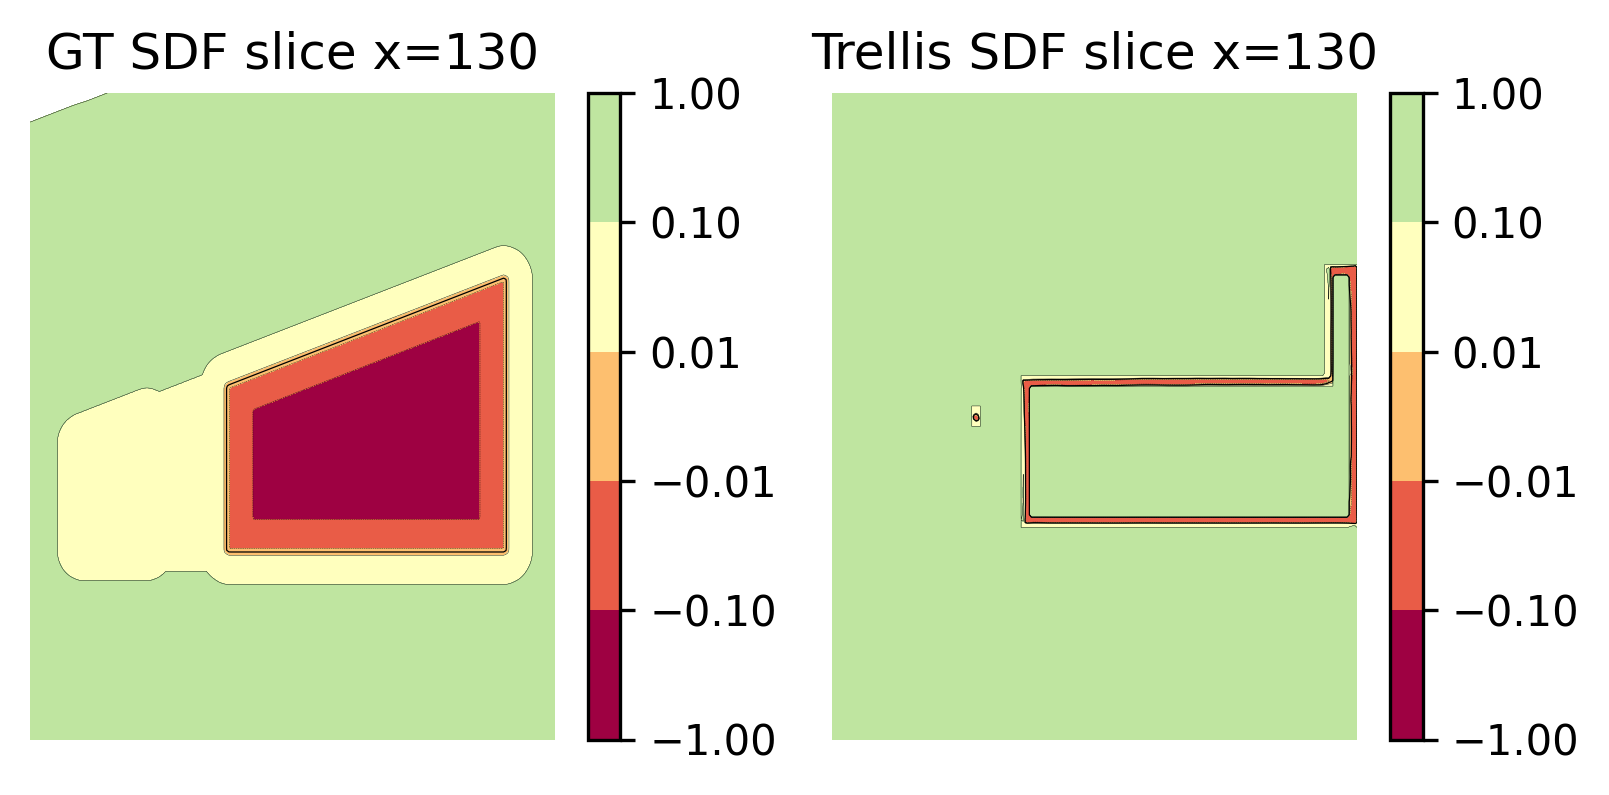

In [73]:
axis = 'x'
slice_ix = 130

fig, ax = plt.subplots(1,2, figsize=(2*2.75,1*2.75), dpi=300)
ax[0] = visu_sdf_slice_contour(gt_sdf, axis, slice_ix, ax=ax[0])
ax[0].set_title(f"GT SDF slice {axis}={slice_ix}")

ax[1] = visu_sdf_slice_contour(tre_sdf, axis, slice_ix, ax=ax[1])
ax[1].set_title(f"Trellis SDF slice {axis}={slice_ix}")
plt.tight_layout()
plt.show()

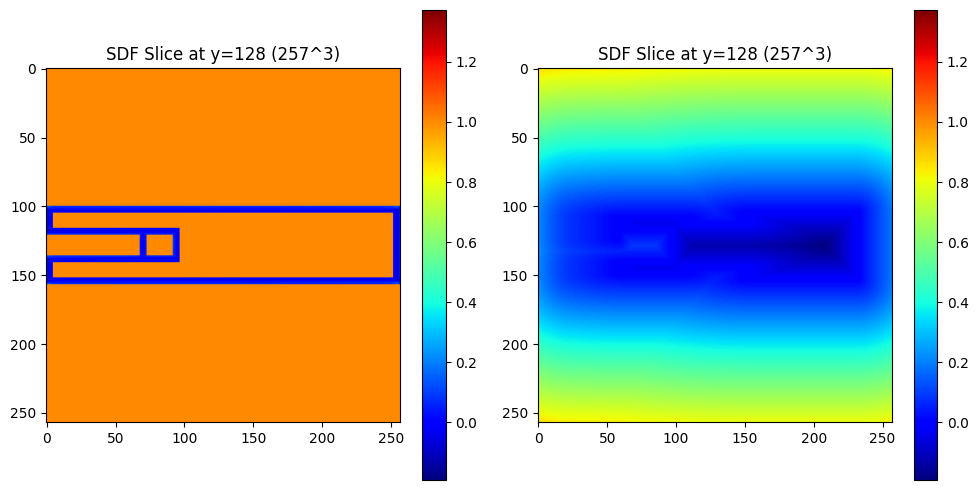

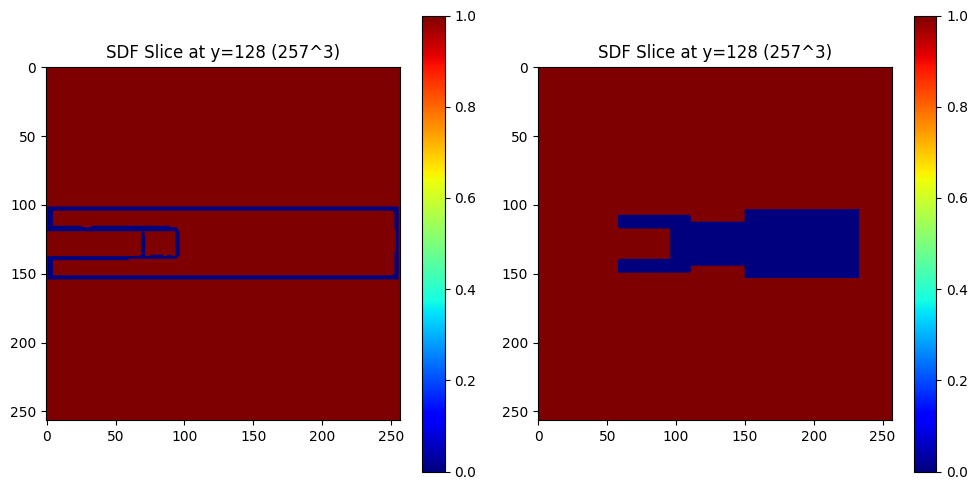

In [18]:
axis = 'y'
slice_ix = 128

# Plot SDF slices
vmin = min(tre_sdf.min(), gt_sdf.min())
vmax = max(tre_sdf.max(), gt_sdf.max())
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.ravel()
ax[0] = visu_sdf_slice(tre_sdf, axis, slice_ix, vmin=vmin, vmax=vmax, ax=ax[0])
ax[1] = visu_sdf_slice(gt_sdf, axis, slice_ix, vmin=vmin, vmax=vmax, ax=ax[1])
plt.tight_layout()

# Plot SDF sign
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.ravel()
ax[0] = visu_sdf_slice(tre_sdf>0, axis, slice_ix, vmin=0, vmax=1, ax=ax[0])
ax[1] = visu_sdf_slice(gt_sdf>0, axis, slice_ix, vmin=0, vmax=1, ax=ax[1])

plt.tight_layout()
plt.show()

In [22]:
band = 0.05

narr_band_stats_tre = narrow_band_stats(tre_sdf, band)
narr_band_stats_gt = narrow_band_stats(gt_sdf, band)
print("Narrow band stats (|sdf| < %.3f):" % band)

for k in narr_band_stats_tre.keys():
    print(f"  {k:<20}: trellis = {narr_band_stats_tre[k]:.2e}, gt = {narr_band_stats_gt[k]:.2e}")

Narrow band stats (|sdf| < 0.050):
  band_fraction       : trellis = 2.04e-02, gt = 5.00e-02
  band_mean           : trellis = -8.40e-03, gt = 6.29e-03
  band_std            : trellis = 2.62e-02, gt = 2.80e-02
  band_p95_abs        : trellis = 4.58e-02, gt = 4.86e-02


In [34]:
stat = compare_to_gt(tre_sdf, gt_sdf, band=band)

print("Comparison to GT")
print(f"	rms error in full volume   			 : {stat['rmse_full']:.2e}")
print(f"	mean abs error band |sdf|<{band:.3f}       : {stat['mae_band']:.2e}")
print(f"	bias (pred-gt) in band |sdf|<{band:.3f}    : {stat['bias_band']:.2e}")

Comparison to GT
	rms error in full volume   			 : 5.57e-01
	mean abs error band |sdf|<0.050       : 7.10e-01
	bias (pred-gt) in band |sdf|<0.050    : 7.00e-01


In [40]:
eik_stats = eikonal_error(tre_sdf[None, None], band=band)
print("Eikonal equation stats for trellis SDF (|sdf| < %.3f):" % band)
for k in eik_stats.keys():
	print(f"  {k:<20}: {eik_stats[k]:.2e}")

eik_stats = eikonal_error(gt_sdf[None, None], band=band)
print("Eikonal equation stats for GT SDF (|sdf| < %.3f):" % band)
for k in eik_stats.keys():
	print(f"  {k:<20}: {eik_stats[k]:.2e}")

Eikonal equation stats for trellis SDF (|sdf| < 0.050):
  mean_grad_norm_band : 1.59e-01
  mean_eikonal_abs_band: 8.41e-01
  max_eikonal_abs_band: 1.00e+00
Eikonal equation stats for GT SDF (|sdf| < 0.050):
  mean_grad_norm_band : 7.66e-03
  mean_eikonal_abs_band: 9.92e-01
  max_eikonal_abs_band: 9.98e-01


In [41]:
print_tensor(gt_sdf, "gt_sdf")

gt_sdf               : torch.Size([257, 257, 257]), min : -0.192, max : 1.372, mean : 0.492, std : 0.278
